In [1]:
!pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [9]:
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pickle
import rasterio
from geocube.api.core import make_geocube
from matplotlib.colors import BoundaryNorm, ListedColormap
from rasterio.features import shapes
from shapely.geometry import box, shape as geom_shape
import geopandas as gpd
import rioxarray as rio
from tqdm.notebook import tqdm

### Function for overlaying NGD OS DATA

Tile paths

In [2]:
# Paths and setup
ROOT = '../predictions'
dirs = {
    'c': os.path.join(ROOT, '_c_v4'),
    'd': os.path.join(ROOT, '_d_v4'),
    'e': os.path.join(ROOT, '_e_v4'),
}

In [38]:
# Get all .tif file paths
tile_paths_c = glob.glob(os.path.join(dirs['c'], '*.tif'))[:10]
tile_paths_d = glob.glob(os.path.join(dirs['d'], '*.tif'))[:10]
tile_paths_e = glob.glob(os.path.join(dirs['e'], '*.tif'))[:10]

In [39]:
# Function to print unique values in a _combined_combined.tif file
def print_unique_values(file_path):
    try:
        # Load the raster file
        data = rio.open_rasterio(file_path)
        
        # Get unique values, ignoring any nodata
        unique_values = np.unique(data.values)
        
        print(f"Unique values in {os.path.basename(file_path)}: {unique_values}")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Check unique values for 'c', 'd', 'e' directories
print("Unique values in 'c' directory:")
for path in tile_paths_c:
    print_unique_values(path)

print("\nUnique values in 'd' directory:")
for path in tile_paths_d:
    print_unique_values(path)

print("\nUnique values in 'e' directory:")
for path in tile_paths_e:
    print_unique_values(path)

Unique values in 'c' directory:
Unique values in SK2380.tif: [0 1 2 3 4]
Unique values in SK0560.tif: [0 1 2 3 4]
Unique values in SK2486.tif: [0 1 2 3 4]
Unique values in SJ9956.tif: [0 1 2 3 4]
Unique values in SJ9469.tif: [0 1 2 3 4]
Unique values in SJ9971.tif: [0 1 2 3 4]
Unique values in SK2778.tif: [0 1 2 3 4]
Unique values in SK0262.tif: [0 1 2 3 4]
Unique values in SJ9766.tif: [0 1 2 3 4]
Unique values in SK2583.tif: [0 1 2 3 4]

Unique values in 'd' directory:
Unique values in SK2380.tif: [0 1 2 3 4 6]
Unique values in SK0560.tif: [0 1 2 3 4 6]
Unique values in SK2486.tif: [0 1 2 3 4 6]
Unique values in SJ9956.tif: [0 1 2 3 4 6]
Unique values in SJ9469.tif: [0 1 2 3 6]
Unique values in SJ9971.tif: [0 1 2 3 4 6]
Unique values in SK2778.tif: [0 1 2 3 4 6]
Unique values in SK0262.tif: [0 1 2 3 4 6]
Unique values in SJ9766.tif: [0 2 3 4 6]
Unique values in SK2583.tif: [0 1 2 3 4 6]

Unique values in 'e' directory:
Unique values in SK2380.tif: [0 2 3 4]
Unique values in SK0560.tif

In [3]:
os_ngd = gpd.read_file('../data/os_ngd/OS_ngd_NL_MHC.shp')
print(os_ngd['ADAPT'].unique())  

['River' 'Pond' 'Lake' 'Canal' 'Suburban' 'Dense urban' 'Cemeteries'
 'Playing fields (i.e. grass without trees)' 'Railway' 'Railway verges'
 'Road' 'Road verges']


Re-Map the NGD

In [4]:
vec_class_map = {
    1: 'River',
    2: 'Lake',
    3: 'Pond',
    4: 'Suburban',
    5: 'Cemeteries',
    6: 'Playing fields (i.e. grass without trees)',
    7: 'Railway verges',
    8:  'Railway',
    9: 'Road',
    10: 'Road verges',
    11: 'Dense urban'
}

re_class_map = dict((v,k) for k,v in vec_class_map.items())

In [5]:
re_class_map

{'River': 1,
 'Lake': 2,
 'Pond': 3,
 'Suburban': 4,
 'Cemeteries': 5,
 'Playing fields (i.e. grass without trees)': 6,
 'Railway verges': 7,
 'Railway': 8,
 'Road': 9,
 'Road verges': 10,
 'Dense urban': 11}

In [8]:
os_ngd['class'] = os_ngd['ADAPT'].map(re_class_map)
os_ngd.to_file('../data/os_ngd_recode.shp')

In [11]:
len(gpd.read_file('../data/os_ngd_recode.shp'))

118663

Better to recode categorical to integer before rasterising

In [14]:
os_ngd_ = gpd.read_file('../data/os_ngd_recode.shp')

In [18]:
print(os_ngd_.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 118663 entries, 0 to 118662
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   ADAPT     118663 non-null  object  
 1   layer     118663 non-null  object  
 2   path      118663 non-null  object  
 3   class     118606 non-null  float64 
 4   geometry  118663 non-null  geometry
dtypes: float64(1), geometry(1), object(3)
memory usage: 4.5+ MB
None


In [21]:
print(os_ngd_['class'].unique())

[ 1.  3.  2. nan  4. 11.  5.  6.  8.  7.  9. 10.]


In [23]:
os_ngd_.tail(10)

,ADAPT,layer,path,class,geometry
118653,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((422042.812 381765.785, 422037.268 38..."
118654,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((423420.110 381828.420, 423421.940 38..."
118655,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((428657.110 387417.380, 428662.310 38..."
118656,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((429548.294 378783.867, 429552.858 37..."
118657,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((423384.114 382910.433, 423385.120 38..."
118658,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((423434.030 381731.190, 423451.580 38..."
118659,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((429894.900 381657.600, 429892.000 38..."
118660,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((423224.355 382914.065, 423224.593 38..."
118661,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((420799.770 383352.910, 420797.970 38..."
118662,Dense urban,os_ngd_NL,/home/david/Documents/Eco/data/os_ngd/os_ngd_N...,11.0,"POLYGON ((422812.200 381451.240, 422812.380 38..."


## Create tifs for OS NGD (only need to run once)

In [ ]:
# Paths
adp_tif_dir = '../ADP/AP'
os_ngd_vector_path = '../data/os_ngd_recode.shp'
output_dir = '../predictions/os_ngd_output'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load vector data
os_ngd_ = gpd.read_file(os_ngd_vector_path)

# Get all ADP TIF file paths
adp_tif_paths = glob.glob(os.path.join(adp_tif_dir, '*.tif'))

# Processing in smaller batches
batch_size = 50  # Adjust based on system capacity

for i in range(0, len(adp_tif_paths), batch_size):
    batch_files = adp_tif_paths[i:i + batch_size]
    
    for adp_path in batch_files:
        try:
            # Open the ADP raster as reference
            reference_raster = rio.open_rasterio(adp_path)

            # Ensure vector data is in the same CRS as the reference raster
            os_ngd_ = os_ngd_.to_crs(reference_raster.rio.crs)

            # Create a bounding box from the reference raster
            bbox = box(*reference_raster.rio.bounds())
            os_ngd_clipped = os_ngd_[os_ngd_.intersects(bbox)]

            # If there's no intersecting data, skip
            if os_ngd_clipped.empty:
                print(f"Skipping {os.path.basename(adp_path)}: No intersecting vector data found.")
                continue

            # Rasterize using the same dimensions and transform as the reference
            os_ngd_raster = make_geocube(
                vector_data=os_ngd_clipped,
                measurements=['class'],
                like=reference_raster,
                fill=0
            )['class']

            # Ensure data type is compact
            os_ngd_raster = os_ngd_raster.astype('uint8')

            # Define output file path based on the ADP TIF name
            output_file_path = os.path.join(output_dir, os.path.basename(adp_path))

            # Save rasterized vector data as .tif with compression
            os_ngd_raster.rio.to_raster(
                output_file_path,
                compress='lzw'  # Use LZW compression to reduce file size
            )

            print(f"Rasterized and saved: {output_file_path}")

        except Exception as e:
            print(f"Failed to process {os.path.basename(adp_path)}: {e}")


## Create the combined raster (single file only)

In [ ]:
# Paths to the individual raster files
c_file = '../predictions/combined_output_c_v4/SK0759.tif'
d_file = '../predictions/combined_output_d_v4/SK0759.tif'
e_file = '../predictions/combined_output_e_v4/SK0759.tif'
os_ngd_file = '../predictions/os_ngd_output/SK0759.tif'
combined_output_file = '../predictions/final_combined_output/SK0759_combined.tif'

# Define class mappings to preserve during combination
priority_mapping = {
    'C': {1: 101, 2: 102, 3: 103, 4: 104},
    'D': {1: 201, 2: 202, 3: 203, 4: 204, 6: 504},
    'E': {2: 302, 3: 303, 4: 504},
    'OS_NGD': {1: 401, 2: 402, 3: 403, 4: 404, 5: 405, 6: 406, 7: 407, 8: 408, 9: 409, 10: 410, 11: 411}
}

def load_and_remap(file_path, mapping):
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(np.int16)
        remapped_data = np.vectorize(mapping.get)(data, data)
    return remapped_data

# Load and remap each layer
c_data = load_and_remap(c_file, priority_mapping['C'])
d_data = load_and_remap(d_file, priority_mapping['D'])
e_data = load_and_remap(e_file, priority_mapping['E'])
os_ngd_data = load_and_remap(os_ngd_file, priority_mapping['OS_NGD'])

# Step-by-step combination with unique value checks
combined_data = np.zeros_like(c_data, dtype=np.int16)
combined_data = np.where(c_data > 0, c_data, combined_data)
print("Unique values after adding C layer:", np.unique(combined_data))

combined_data = np.where(d_data > 0, d_data, combined_data)
print("Unique values after adding D layer:", np.unique(combined_data))

combined_data = np.where(e_data > 0, e_data, combined_data)
print("Unique values after adding E layer:", np.unique(combined_data))

combined_data = np.where(os_ngd_data > 0, os_ngd_data, combined_data)
print("Unique values after adding OS_NGD layer:", np.unique(combined_data))

# Save the combined output
meta_combined = rasterio.open(c_file).meta.copy()
meta_combined.update(dtype='int16')

with rasterio.open(combined_output_file, 'w', **meta_combined) as dst:
    dst.write(combined_data, 1)

print(f"Combined raster saved to {combined_output_file}")

Unique values after adding C layer: [  0 101 102 103 104]
Unique values after adding D layer: [  0 101 102 103 104 201 202 203 204 504]
Unique values after adding E layer: [101 102 103 104 201 202 203 204 302 303 504]
Unique values after adding OS_NGD layer: [101 102 103 104 201 202 203 204 302 303 403 404 409 410 411 504]
Combined raster saved to ../predictions/final_combined_output/SK0759_combined.tif


In [32]:
# create the class colours dic
class_colors_combined = {
    0: 'lightgrey',         # No Class
    101: 'darkgreen',       # Broadleaved Woodland (C)
    102: 'green',           # Coniferous Woodland (C)
    103: 'olive',           # Scrub (C)
    104: 'brown',           # Felled/Young Trees (C)
    201: 'purple',          # Heather Moorland (D)
    202: 'plum',            # Upland Grass Moor (D)
    203: 'yellow',          # Bracken (D)
    204: 'gold',            # Mosaic (D)
    504: 'red',             # Rush Pasture (E, shared with D)
    302: 'lightgreen',      # Improved Grassland (E)
    303: 'limegreen',       # Rough Grassland (E)
    401: 'blue',            # River (OS NGD)
    402: 'cyan',            # Lake (OS NGD)
    403: 'lightblue',       # Pond (OS NGD)
    404: 'grey',            # Suburban (OS NGD)
    405: 'grey',            # Cemeteries (OS NGD)
    406: 'lightgreen',      # Playing Fields (OS NGD)
    407: 'black',           # Railway Verges (OS NGD)
    408: 'black',           # Railway (OS NGD)
    409: 'black',           # Road (OS NGD)
    410: 'grey',            # Road Verges (OS NGD)
    411: 'black'            # Dense Urban (OS NGD)
}

## Plot example (single file only)

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Load the combined raster
combined_raster_path = "../predictions/final_combined_output/SK0759_combined.tif"
with rasterio.open(combined_raster_path) as src:
    combined_data = src.read(1)

# Extract unique values from the combined_data for color alignment
unique_values = np.unique(combined_data)
print("Unique values in combined data for visualization:", unique_values)

# Filter class_colors_combined to only include keys present in unique_values
filtered_colors = {key: class_colors_combined[key] for key in unique_values if key in class_colors_combined}
print("Filtered color map:", filtered_colors)

# Create color map and legend based on filtered colors
colors = [filtered_colors[val] for val in sorted(filtered_colors.keys())]
cmap = ListedColormap(colors)

# Create legend patches
legend_patches = [mpatches.Patch(color=filtered_colors[val], label=str(val)) for val in sorted(filtered_colors.keys())]

# Plot the combined raster with color mapping
plt.figure(figsize=(10, 10))
plt.imshow(combined_data, cmap=cmap)

# Add legend
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), title="Class Values")
plt.title("Final Combined Raster with Class Values")
plt.axis("off")
plt.show()


## Convert to Shapefile (single file only)

In [1]:
class_colors_combined = {
    0: ('lightgrey', 'No Class', '(nan)'),
    101: ('darkgreen', 'Broadleaved Woodland', 'C101'),
    102: ('green', 'Coniferous Woodland', 'C102'),
    103: ('olive', 'Scrub', 'C103'),
    104: ('brown', 'Felled/Young Trees', 'C104'),
    201: ('purple', 'Heather Moorland', 'D201'),
    202: ('plum', 'Upland Grass Moor', 'D202'),
    203: ('yellow', 'Bracken', 'D203'),
    204: ('gold', 'Mosaic', 'D204'),
    504: ('red', 'Rush Pasture', 'E504'),
    302: ('lightgreen', 'Improved Grassland', 'E302'),
    303: ('limegreen', 'Rough Grassland', 'E303'),
    401: ('blue', 'River', 'OS401'),
    402: ('cyan', 'Lake', 'OS402'),
    403: ('lightblue', 'Pond', 'OS403'),
    404: ('grey', 'Suburban', 'OS404'),
    405: ('grey', 'Cemeteries', 'OS405'),
    406: ('lightgreen', 'Playing Fields', 'OS406'),
    407: ('black', 'Railway Verges', 'OS407'),
    408: ('black', 'Railway', 'OS408'),
    409: ('black', 'Road', 'OS409'),
    410: ('grey', 'Road Verges', 'OS410'),
    411: ('black', 'Dense Urban', 'OS411')
}


In [ ]:
# File paths
combined_raster_path = '../predictions/final_combined_output/SK0759_combined.tif'
output_shapefile_path = '../shapefiles/final_combined_output/SK0759_combined.shp'

# Load the raster data
with rasterio.open(combined_raster_path) as src:
    raster_data = src.read(1)  # Read the first band
    transform = src.transform

    # Polygonize the raster
    polygons = []
    for geom, value in shapes(raster_data, transform=transform):
        if value in class_colors_combined:
            color, description, code = class_colors_combined[value]
            polygons.append({
                'geometry': shape(geom),
                'value': value,
                'color': color,
                'ADAPT': description,
                'code': code
            })

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(polygons)

# Save the GeoDataFrame as a shapefile
gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

print(f"Shapefile saved to {output_shapefile_path}")


Shapefile saved to ../predictions/test


## Batch output now it works

Sometimes the os data may not be present. It seemed to be confusing the processing

1. Check if each file exists for a given tile.
2. If a file is missing, initialize its data as an array of zeros, allowing the code to combine without skipping tiles.

In [ ]:
# Define class mappings to preserve during combination
priority_mapping = {
    'C': {1: 101, 2: 102, 3: 103, 4: 104},
    'D': {1: 201, 2: 202, 3: 203, 4: 204, 6: 504},
    'E': {2: 302, 3: 303, 4: 504},
    'OS_NGD': {1: 401, 2: 402, 3: 403, 4: 404, 5: 405, 6: 406, 7: 407, 8: 408, 9: 409, 10: 410, 11: 411}
}

class_colors_combined = {
    0: ('lightgrey', 'No Class', '(nan)'),
    101: ('darkgreen', 'Broadleaved Woodland', 'C101'),
    102: ('green', 'Coniferous Woodland', 'C102'),
    103: ('olive', 'Scrub', 'C103'),
    104: ('brown', 'Felled/Young Trees', 'C104'),
    201: ('purple', 'Heather Moorland', 'D201'),
    202: ('plum', 'Upland Grass Moor', 'D202'),
    203: ('yellow', 'Bracken', 'D203'),
    204: ('gold', 'Mosaic', 'D204'),
    504: ('red', 'Rush Pasture', 'E504'),
    302: ('lightgreen', 'Improved Grassland', 'E302'),
    303: ('limegreen', 'Rough Grassland', 'E303'),
    401: ('blue', 'River', 'OS401'),
    402: ('cyan', 'Lake', 'OS402'),
    403: ('lightblue', 'Pond', 'OS403'),
    404: ('grey', 'Suburban', 'OS404'),
    405: ('grey', 'Cemeteries', 'OS405'),
    406: ('lightgreen', 'Playing Fields', 'OS406'),
    407: ('black', 'Railway Verges', 'OS407'),
    408: ('black', 'Railway', 'OS408'),
    409: ('black', 'Road', 'OS409'),
    410: ('grey', 'Road Verges', 'OS410'),
    411: ('black', 'Dense Urban', 'OS411')
}

def load_and_remap(file_path, mapping, shape=None):
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1).astype(np.int16)
            remapped_data = np.vectorize(mapping.get)(data, data)
    else:
        # Initialize with zeros if the file does not exist
        if shape:
            remapped_data = np.zeros(shape, dtype=np.int16)
        else:
            raise ValueError("Shape must be provided when file is missing.")
    return remapped_data

# Directory paths for input and output
c_files = glob.glob('../predictions/_c_v4/*.tif')
d_files = glob.glob('../predictions/_d_v4/*.tif')
e_files = glob.glob('../predictions/_e_v4/*.tif')
os_ngd_files = glob.glob('../predictions/os_ngd_output/*.tif')
combined_output_dir = '../predictions/final_combined_output/'
output_shapefile_dir = '../shapefiles/final_combined_output/'

# Ensure output directories exist
os.makedirs(combined_output_dir, exist_ok=True)
os.makedirs(output_shapefile_dir, exist_ok=True)

# Match files by tile name (SK####)
tile_ids = set([os.path.basename(f).replace('.tif', '') for f in c_files])

for tile_id in tile_ids:
    # Paths for each tile
    c_file = f'../predictions/_c_v4/{tile_id}.tif'
    d_file = f'../predictions/_d_v4/{tile_id}.tif'
    e_file = f'../predictions/_e_v4/{tile_id}.tif'
    os_ngd_file = f'../predictions/os_ngd_output/{tile_id}.tif'
    
    combined_output_file = os.path.join(combined_output_dir, f"{tile_id}_combined.tif")
    output_shapefile_path = os.path.join(output_shapefile_dir, f"{tile_id}_combined.shp")
    
    # Open a reference raster to get the shape if needed
    with rasterio.open(c_file) as ref:
        shape = ref.shape

    # Load and remap each layer (using zeros for missing layers)
    c_data = load_and_remap(c_file, priority_mapping['C'], shape)
    d_data = load_and_remap(d_file, priority_mapping['D'], shape)
    e_data = load_and_remap(e_file, priority_mapping['E'], shape)
    os_ngd_data = load_and_remap(os_ngd_file, priority_mapping['OS_NGD'], shape)

    # Step-by-step combination with priority
    combined_data = np.zeros(shape, dtype=np.int16)
    combined_data = np.where(c_data > 0, c_data, combined_data)
    combined_data = np.where(d_data > 0, d_data, combined_data)
    combined_data = np.where(e_data > 0, e_data, combined_data)
    combined_data = np.where(os_ngd_data > 0, os_ngd_data, combined_data)

    # Save the combined raster
    with rasterio.open(c_file) as src:
        meta_combined = src.meta.copy()
        meta_combined.update(dtype='int16')
        with rasterio.open(combined_output_file, 'w', **meta_combined) as dst:
            dst.write(combined_data, 1)
    print(f"Combined raster saved to {combined_output_file}")

    # Convert to shapefile
    with rasterio.open(combined_output_file) as src:
        raster_data = src.read(1)
        transform = src.transform

        polygons = []
        for geom, value in shapes(raster_data, transform=transform):
            if value in class_colors_combined:
                color, description, code = class_colors_combined[value]
                polygons.append({
                    'geometry': geom_shape(geom),  # Use geom_shape here
                    'value': value,
                    'color': color,
                    'ADAPT': description,
                    'code': code
                })

    # Create a GeoDataFrame and save as shapefile
    gdf = gpd.GeoDataFrame(polygons)
    gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')
    print(f"Shapefile saved to {output_shapefile_path}")


# Batch Output from Soils process

In [ ]:
# Directories
input_dir = "../predictions/dissolved_output_with_soils/"
output_dir = "../shapefiles/final_combined_output/"

# Ensure the output directory
os.makedirs(output_dir, exist_ok=True)

# Updated class mapping with new classes
class_colors_combined = {
    0: ('#D3D3D3', 'No Class', '(nan)'),  # Light grey
    101: ('#006400', 'Broadleaved Woodland', 'C101'),  # Dark green
    102: ('#008000', 'Coniferous Woodland', 'C102'),  # Green
    103: ('#808000', 'Scrub', 'C103'),  # Olive
    104: ('#A52A2A', 'Felled/Young Trees', 'C104'),  # Brown
    201: ('#800080', 'Heather Moorland', 'D201'),  # Purple
    202: ('#DDA0DD', 'Upland Grass Moor', 'D202'),  # Plum
    203: ('#FFFF00', 'Bracken', 'D203'),  # Yellow
    204: ('#FFD700', 'Mosaic', 'D204'),  # Gold
    504: ('#FF0000', 'Rush Pasture', 'E504'),  # Red
    302: ('#90EE90', 'Improved Grassland', 'E302'),  # Light green
    303: ('#32CD32', 'Rough Grassland', 'E303'),  # Lime green
    401: ('#0000FF', 'River', 'OS401'),  # Blue
    402: ('#00FFFF', 'Lake', 'OS402'),  # Cyan
    403: ('#ADD8E6', 'Pond', 'OS403'),  # Light blue
    404: ('#808080', 'Suburban', 'OS404'),  # Grey
    405: ('#808080', 'Cemeteries', 'OS405'),  # Grey (same as Suburban)
    406: ('#90EE90', 'Playing Fields', 'OS406'),  # Light green (same as Improved Grassland)
    407: ('#000000', 'Railway Verges', 'OS407'),  # Black
    408: ('#000000', 'Railway', 'OS408'),  # Black
    409: ('#000000', 'Road', 'OS409'),  # Black
    410: ('#808080', 'Road Verges', 'OS410'),  # Grey (same as Suburban)
    411: ('#000000', 'Dense Urban', 'OS411'),  # Black
    205: ('#FF00FF', 'Heather Moorland on blanket bog/deep peat', 'D205'),  # Magenta
    206: ('#FF1493', 'Upland Grass Moor on blanket bog/deep peat', 'D206'), # Deep pink
    207: ('#FF69B4', 'Mosaic on blanket bog/deep peat', 'D207')            # Hot pink
}

# Process each raster file 
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        raster_path = os.path.join(input_dir, filename)
        output_shapefile_path = os.path.join(output_dir, filename.replace(".tif", ".shp"))

        # Load raster data
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Read the first band
            transform = src.transform

            # Polygonize raster
            polygons = []
            for geom, value in shapes(raster_data, transform=transform):
                if value in class_colors_combined:
                    color, description, code = class_colors_combined[value]
                    polygons.append({
                        'geometry': shape(geom),
                        'value': value,
                        'color': color,
                        'ADAPT': description,
                        'code': code
                    })

        # Save as .shp
        gdf = gpd.GeoDataFrame(polygons)
        gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

        print(f"Shapefile saved to {output_shapefile_path}")

print("Batch processing completed.")


In [1]:
## Plot shapefile test

                  ADAPT      color
0               Bracken     yellow
1  Broadleaved Woodland  darkgreen
2  Broadleaved Woodland  darkgreen
3               Bracken     yellow
4  Broadleaved Woodland  darkgreen


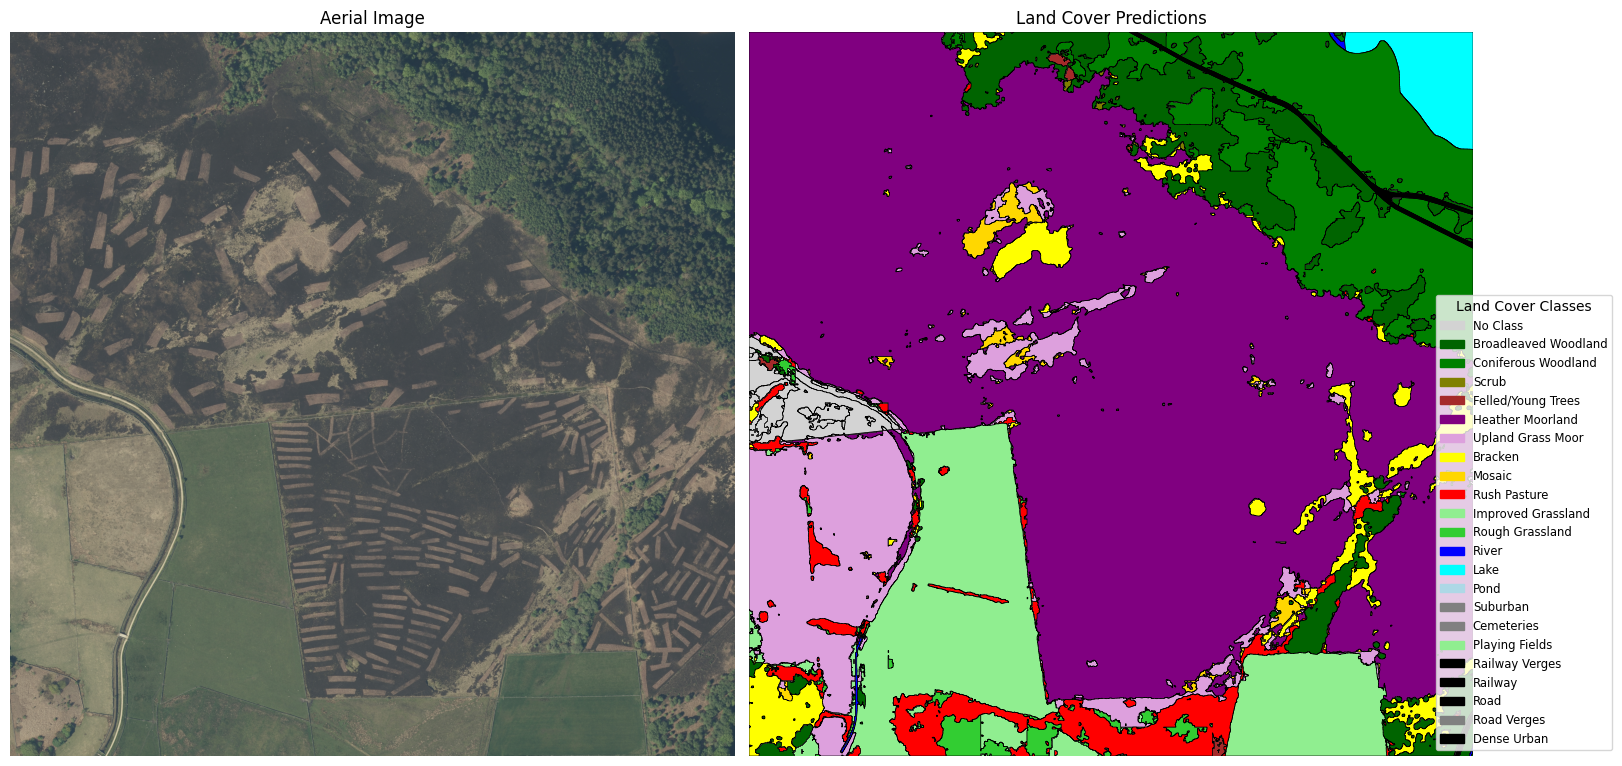

In [8]:
# Set a default font family explicitly to avoid warnings
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # A default font included with matplotlib

# Paths to the single tile and prediction files
adp_tile_path = '/home/david/Documents/Eco/ADP/AP/SK2686.tif'
prediction_path = '/home/david/Documents/Eco/shapefiles/final_combined_output/SK2686_combined.shp'  # Example prediction file

class_colors_combined = {
    'No Class': 'lightgrey',
    'Broadleaved Woodland': 'darkgreen',
    'Coniferous Woodland': 'green',
    'Scrub': 'olive',
    'Felled/Young Trees': 'brown',
    'Heather Moorland': 'purple',
    'Upland Grass Moor': 'plum',
    'Bracken': 'yellow',
    'Mosaic': 'gold',
    'Rush Pasture': 'red',
    'Improved Grassland': 'lightgreen',
    'Rough Grassland': 'limegreen',
    'River': 'blue',
    'Lake': 'cyan',
    'Pond': 'lightblue',
    'Suburban': 'grey',
    'Cemeteries': 'grey',
    'Playing Fields': 'lightgreen',
    'Railway Verges': 'black',
    'Railway': 'black',
    'Road': 'black',
    'Road Verges': 'grey',
    'Dense Urban': 'black'
}

# Load the RGB raster tile
with rasterio.open(adp_tile_path) as src:
    adp_image = src.read([1, 2, 3])  # Read the first three bands for RGB
    adp_extent = src.bounds  # Get the bounds for plotting

# Load the prediction vector file
prediction_data = gpd.read_file(prediction_path)

# Map colors based on descriptive names in `ADAPT`
prediction_data['color'] = prediction_data['ADAPT'].map(class_colors_combined).fillna('lightgrey')

# Check if color mapping is applied correctly
print(prediction_data[['ADAPT', 'color']].head())  # Debug output to verify colors

# Set up the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Plot the RGB aerial image on the first subplot
axes[0].imshow(adp_image.transpose(1, 2, 0), extent=[adp_extent.left, adp_extent.right, adp_extent.bottom, adp_extent.top])
axes[0].set_title("Aerial Image")
axes[0].axis("off")

# Plot land cover predictions with colors
prediction_data.plot(ax=axes[1], color=prediction_data['color'], edgecolor="k", linewidth=0.5)

axes[1].set_xlim(adp_extent.left, adp_extent.right)
axes[1].set_ylim(adp_extent.bottom, adp_extent.top)
axes[1].set_title("Land Cover Predictions")
axes[1].axis("off")

# Create a legend for prediction classes
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in class_colors_combined.items()]
axes[1].legend(handles=legend_patches, loc='lower right', title="Land Cover Classes", fontsize="small", bbox_to_anchor=(1.2, 0))

plt.tight_layout()
plt.show()

# Fix some labels

In [ ]:
## Fix some labels

In [70]:
input_files_d6a = [
    '../predictions/final_combined_output/SK2880_combined.tif'
]

In [81]:
input_files_c1 = [
    '../predictions/final_combined_output/SK1364_combined.tif',
    '../predictions/final_combined_output/SK0167_combined.tif',
]

In [17]:
# to rushpasture
input_files = [
    '../predictions/final_combined_output/SK0360_combined.tif',
    '../predictions/final_combined_output/SK0260_combined.tif',
    '../predictions/final_combined_output/SK0361_combined.tif',
    '../predictions/final_combined_output/SK0261_combined.tif',
    '../predictions/final_combined_output/SK0161_combined.tif',
    '../predictions/final_combined_output/SK0160_combined.tif',
    '../predictions/final_combined_output/SK0162_combined.tif',
    '../predictions/final_combined_output/SK0262_combined.tif',
    '../predictions/final_combined_output/SK0362_combined.tif',
    '../predictions/final_combined_output/SK0461_combined.tif',
    '../predictions/final_combined_output/SK0462_combined.tif',
    '../predictions/final_combined_output/SK0460_combined.tif',
    '../predictions/final_combined_output/SK0066_combined.tif',
    '../predictions/final_combined_output/SK0269_combined.tif',
    '../predictions/final_combined_output/SK0268_combined.tif',
    '../predictions/final_combined_output/SK0560_combined.tif',
    '../predictions/final_combined_output/SK0660_combined.tif',
    '../predictions/final_combined_output/SK0663_combined.tif',
    '../predictions/final_combined_output/SK0563_combined.tif',
    '../predictions/final_combined_output/SK0462_combined.tif',
    '../predictions/final_combined_output/SK0464_combined.tif',
    '../predictions/final_combined_output/SK0364_combined.tif',
    '../predictions/final_combined_output/SK0165_combined.tif',
    '../predictions/final_combined_output/SK0065_combined.tif',
    '../predictions/final_combined_output/SJ9965_combined.tif',
    '../predictions/final_combined_output/SK0166_combined.tif',
    '../predictions/final_combined_output/SK0266_combined.tif',
    '../predictions/final_combined_output/SK0368_combined.tif',
    '../predictions/final_combined_output/SK0364_combined.tif',
    '../predictions/final_combined_output/SK0271_combined.tif',
    '../predictions/final_combined_output/SK0272_combined.tif',
    '../predictions/final_combined_output/SK1354_combined.tif',
    '../predictions/final_combined_output/SK2486_combined.tif',
    '../predictions/final_combined_output/SK2286_combined.tif',
    '../predictions/final_combined_output/SK2185_combined.tif',
    '../predictions/final_combined_output/SK2285_combined.tif',
    '../predictions/final_combined_output/SK2187_combined.tif',
    '../predictions/final_combined_output/SK2287_combined.tif',
    '../predictions/final_combined_output/SK2388_combined.tif',
    '../predictions/final_combined_output/SK2483_combined.tif',
    '../predictions/final_combined_output/SK2482_combined.tif',
    '../predictions/final_combined_output/SK2382_combined.tif'
]

In [87]:
# more rush conversion
input_files = [
    '../predictions/final_combined_output/SK0364_combined.tif',
    '../predictions/final_combined_output/SK0464_combined.tif',
    '../predictions/final_combined_output/SK0663_combined.tif',
    '../predictions/final_combined_output/SK0762_combined.tif',
    '../predictions/final_combined_output/SK0761_combined.tif',
    '../predictions/final_combined_output/SK0861_combined.tif',
    '../predictions/final_combined_output/SK0860_combined.tif',
    '../predictions/final_combined_output/SK0760_combined.tif',
]

In [89]:
# more rush conversion
input_files = [
    '../predictions/final_combined_output/SK0353_combined.tif',
    '../predictions/final_combined_output/SK0064_combined.tif',
    '../predictions/final_combined_output/SK0064_combined.tif',
    '../predictions/final_combined_output/SJ9969_combined.tif'
]

In [91]:
# 104 to d6a
# more rush conversion
input_files = [
    '../predictions/final_combined_output/SJ9971_combined.tif'
]

In [93]:
# d1a to RG
input_files = [
    '../predictions/final_combined_output/SK1162_combined.tif',
    '../predictions/final_combined_output/SK1159_combined.tif',
    '../predictions/final_combined_output/SK1154_combined.tif',
    '../predictions/final_combined_output/SK1053_combined.tif',
    '../predictions/final_combined_output/SK1353_combined.tif',
    '../predictions/final_combined_output/SK0554_combined.tif',
    '../predictions/final_combined_output/SK0453_combined.tif',
    '../predictions/final_combined_output/SK0154_combined.tif',
    '../predictions/final_combined_output/SK0054_combined.tif',
    '../predictions/final_combined_output/SK0053_combined.tif',
    '../predictions/final_combined_output/SJ9873_combined.tif',
    '../predictions/final_combined_output/SJ9773_combined.tif'
]

In [94]:
# Output directory for relabeled rasters
output_dir = '../predictions/relabeled_output'
os.makedirs(output_dir, exist_ok=True)

# Process each file
for file_path in input_files:
    # Generate output file path in the output directory
    base_name = os.path.basename(file_path)  # Get filename only
    output_path = os.path.join(output_dir, base_name)  # Save to the output directory

    # Open the input raster file
    with rasterio.open(file_path) as src:
        # Read the raster data
        raster_data = src.read(1)
        
        # Replace the code 104 with 504
        raster_data[raster_data == 201] = 303
        
        # Prepare metadata for writing
        metadata = src.meta
    
    # Write the updated raster to the output file
    with rasterio.open(output_path, 'w', **metadata) as dst:
        dst.write(raster_data, 1)

    print(f"Processed and saved updated raster to {output_path}")

Processed and saved updated raster to ../predictions/relabeled_output/SK1162_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK1159_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK1154_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK1053_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK1353_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK0554_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK0453_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK0154_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK0054_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SK0053_combined.tif
Processed and saved updated raster to ../predictions/relabeled_output/SJ9873_combined.tif
Processed 

In [ ]:
# Path to the raster file
raster_path = '../predictions/final_combined_output/SK0360_combined.tif'

# Open the raster file and print metadata and unique values
with rasterio.open(raster_path) as src:
    # Print metadata
    print("Metadata:", src.meta)
    
    # Read the data into a numpy array
    raster_data = src.read(1)  # Reading the first band
    
    # Display unique values
    unique_values = np.unique(raster_data)
    print("Unique values in the raster:", unique_values)
    
    # Print data type and shape for further inspection
    print("Data type:", raster_data.dtype)
    print("Shape:", raster_data.shape)

Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 8000, 'height': 8000, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(0.125, 0.0, 403000.0,
       0.0, -0.125, 361000.0)}
Unique values in the raster: [101 102 103 104 201 202 203 204 302 303 401 403 404 409 410 411 504]
Data type: int16
Shape: (8000, 8000)


Unique values in combined raster data: [101 102 103 104 201 202 203 302 303 403 404 409 410 411 504]


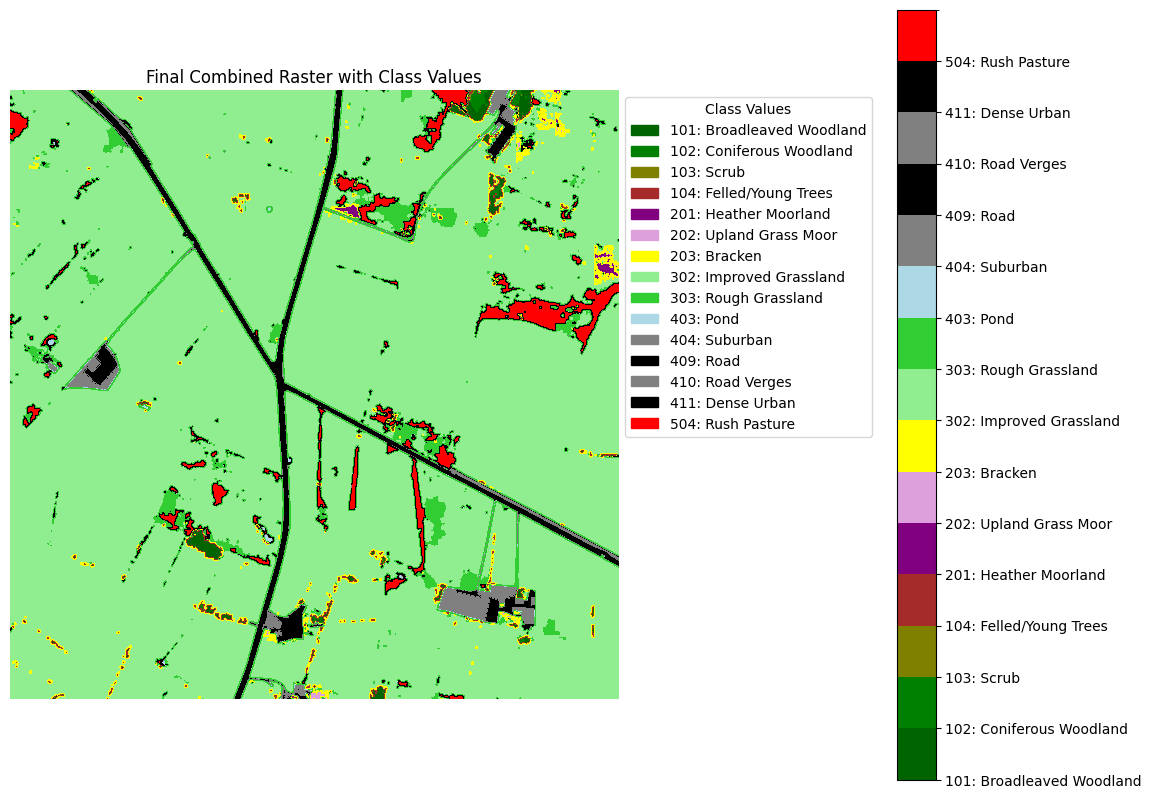

In [ ]:
# Define class color mapping and labels
class_colors_combined = {
    101: ('darkgreen', 'Broadleaved Woodland'),
    102: ('green', 'Coniferous Woodland'),
    103: ('olive', 'Scrub'),
    104: ('brown', 'Felled/Young Trees'),
    201: ('purple', 'Heather Moorland'),
    202: ('plum', 'Upland Grass Moor'),
    203: ('yellow', 'Bracken'),
    204: ('gold', 'Mosaic'),
    302: ('lightgreen', 'Improved Grassland'),
    303: ('limegreen', 'Rough Grassland'),
    403: ('lightblue', 'Pond'),
    404: ('grey', 'Suburban'),
    409: ('black', 'Road'),
    410: ('grey', 'Road Verges'),
    411: ('black', 'Dense Urban'),
    504: ('red', 'Rush Pasture')
}

# Load the combined raster
combined_raster_path = "../predictions/final_combined_output/SK0453_combined.tif"
with rasterio.open(combined_raster_path) as src:
    combined_data = src.read(1)

# Extract unique values in the raster data for color mapping
unique_values = np.unique(combined_data)
print("Unique values in combined raster data:", unique_values)

# Filter colors and labels based on unique raster values
filtered_colors = {key: class_colors_combined[key][0] for key in unique_values if key in class_colors_combined}
filtered_labels = {key: f"{key}: {class_colors_combined[key][1]}" for key in unique_values if key in class_colors_combined}

# Prepare colormap and normalization specifically for unique values only
colors = [filtered_colors[val] for val in sorted(filtered_colors.keys())]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=sorted(filtered_colors.keys()) + [max(filtered_colors.keys()) + 1], ncolors=len(colors))

# Create legend patches
legend_patches = [mpatches.Patch(color=filtered_colors[val], label=filtered_labels[val]) for val in sorted(filtered_colors.keys())]

# Plot the combined raster data with color mapping
plt.figure(figsize=(12, 10))
im = plt.imshow(combined_data, cmap=cmap, norm=norm)

# Create a custom color bar with discrete values
cbar = plt.colorbar(im, ticks=sorted(filtered_colors.keys()), orientation="vertical", fraction=0.046, pad=0.30)
cbar.ax.set_yticklabels([filtered_labels[val] for val in sorted(filtered_labels.keys())])

# Add legend
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), title="Class Values")
plt.title("Final Combined Raster with Class Values")
plt.grid(visible=True)  # Enable grid to assist in value-color alignment
plt.axis("off")
plt.show()

plt.show()





Unique values in combined raster data: [101 102 103 104 202 203 204 302 303 401 404 409 410 411 504]


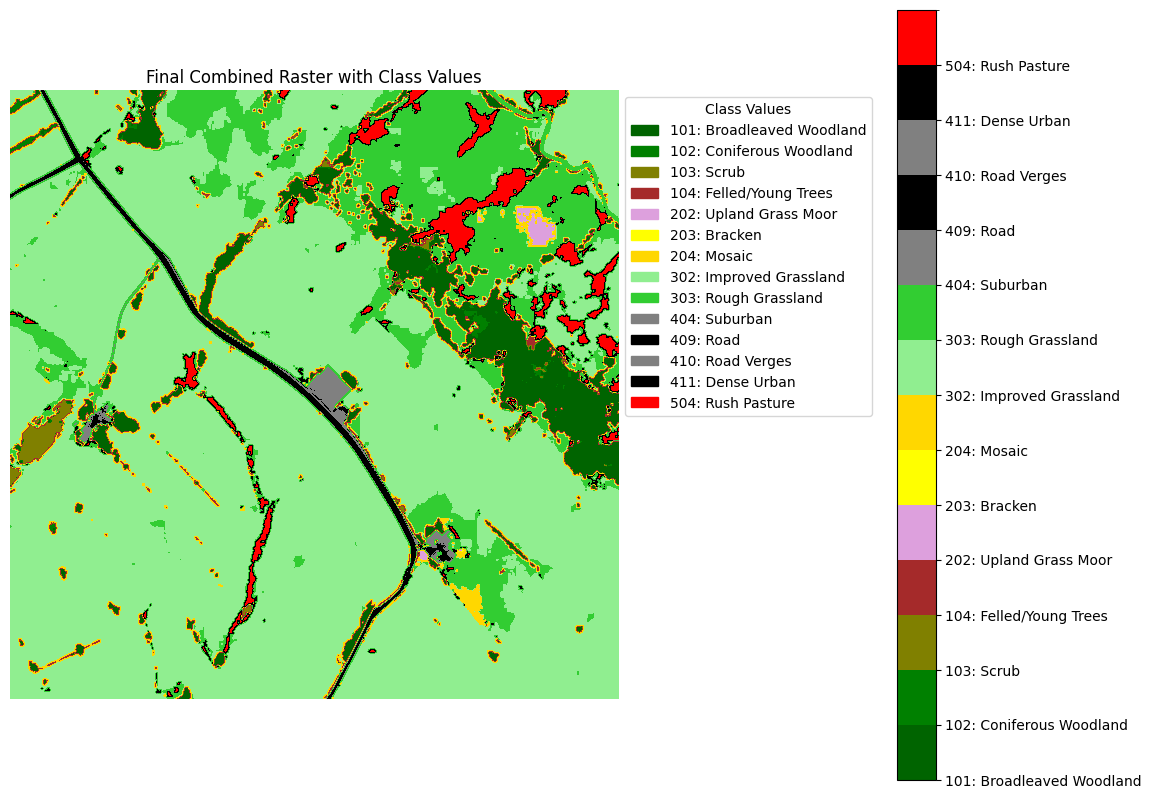

In [98]:
# Define class color mapping and labels
class_colors_combined = {
    101: ('darkgreen', 'Broadleaved Woodland'),
    102: ('green', 'Coniferous Woodland'),
    103: ('olive', 'Scrub'),
    104: ('brown', 'Felled/Young Trees'),
    201: ('purple', 'Heather Moorland'),
    202: ('plum', 'Upland Grass Moor'),
    203: ('yellow', 'Bracken'),
    204: ('gold', 'Mosaic'),
    302: ('lightgreen', 'Improved Grassland'),
    303: ('limegreen', 'Rough Grassland'),
    403: ('lightblue', 'Pond'),
    404: ('grey', 'Suburban'),
    409: ('black', 'Road'),
    410: ('grey', 'Road Verges'),
    411: ('black', 'Dense Urban'),
    504: ('red', 'Rush Pasture')
}

# Load the combined raster
combined_raster_path = "../predictions/relabeled_output/SK1162_combined.tif"
with rasterio.open(combined_raster_path) as src:
    combined_data = src.read(1)

# Extract unique values in the raster data for color mapping
unique_values = np.unique(combined_data)
print("Unique values in combined raster data:", unique_values)

# Filter colors and labels based on unique raster values
filtered_colors = {key: class_colors_combined[key][0] for key in unique_values if key in class_colors_combined}
filtered_labels = {key: f"{key}: {class_colors_combined[key][1]}" for key in unique_values if key in class_colors_combined}

# Prepare colormap and normalization specifically for unique values only
colors = [filtered_colors[val] for val in sorted(filtered_colors.keys())]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=sorted(filtered_colors.keys()) + [max(filtered_colors.keys()) + 1], ncolors=len(colors))

# Create legend patches
legend_patches = [mpatches.Patch(color=filtered_colors[val], label=filtered_labels[val]) for val in sorted(filtered_colors.keys())]

# Plot the combined raster data with color mapping
plt.figure(figsize=(12, 10))
im = plt.imshow(combined_data, cmap=cmap, norm=norm)

# Create a custom color bar with discrete values
cbar = plt.colorbar(im, ticks=sorted(filtered_colors.keys()), orientation="vertical", fraction=0.046, pad=0.30)
cbar.ax.set_yticklabels([filtered_labels[val] for val in sorted(filtered_labels.keys())])

# Add legend
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), title="Class Values")
plt.title("Final Combined Raster with Class Values")
plt.grid(visible=True)  # Enable grid to assist in value-color alignment
plt.axis("off")
plt.show()

plt.show()